# Library Imports

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc import math as pm_math
from scipy.stats import halfnorm, skewnorm

# Model Specification

# Model Specification
## Simulated Data
$$ X \sim N(1,1) $$
$$ U \sim HN(0, \sigma_u^2) $$
$$ Y \sim SN(\xi, \sigma_v^2, \lambda)$$
$$ \xi = \alpha + \beta X - U $$
$$ \alpha = 5, \beta = 2 $$
## Priors
$$ \alpha \sim N(\mu_\alpha, \sigma_\alpha^2) $$
$$ \beta \sim N(\mu_\beta, \sigma_\beta^2) $$
$$ \sigma_v^2 \sim IG(\alpha_v, \beta_v) $$
$$ \sigma_u^2 \sim IG(\alpha_u, \beta_u) $$
$$ \lambda \sim TN(\mu_\lambda, \sigma_\lambda^2; a, b)$$


# Simulate Data: $$ \lambda = -0.5 $$

# Trace container: Skew

In [2]:
trace_skew = []

# Trace container: Normal

In [3]:
trace_norm = []

# List of sample sizes

In [4]:
sample_size = [50, 100, 200, 500]

# Model Generation: Skew Normal

In [ ]:
def skew_norm(sample_size):
    np.random.seed(123)

    # Parameters
    n = sample_size
    alpha = 5
    beta = 2
    sigma_u = 1
    sigma_v = 1.5
    lambda_skew = -1

    # Simulate input X
    X = np.random.normal(1, 1, n)

    # Inefficiency term U ~ HalfNormal(0, sigma_u)
    U = halfnorm(scale=sigma_u).rvs(n)

    # Location ξ = α + βX − U
    xi = alpha + beta * X - U

    # Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
    Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

    # Put in DataFrame for convenience
    data = pd.DataFrame({'X': X, 'Y': Y})

    # Generate Model
    with pm.Model() as model:
        # Priors for parameters
        alpha_ = pm.Normal('alpha', mu=5, sigma=5)
        beta_ = pm.Normal('beta', mu=2, sigma=2)
        sigma_u = pm.InverseGamma('sigma_u', alpha=4, beta=3)
        sigma_v = pm.InverseGamma('sigma_v', alpha=2, beta=3)
        lam = pm.TruncatedNormal('lam', mu=-1, sigma=1, lower=-4, upper=0)

        # Latent inefficiency U ~ HalfNormal(0, sigma_u)
        U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

        # Linear predictor with inefficiency
        mu = alpha_ + beta_ * data['X'] - U

        # Skew-Normal likelihood
        Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

        # MCMC Sampling
        trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True, compute_covergence_checks=True, idata_kwargs={"log_likelihood": True})
        return model, trace

# Model Generation: Normal

In [6]:
def norm(sample_size):
    np.random.seed(123)

    # Parameters
    n = sample_size
    alpha = 5
    beta = 2
    sigma_u = 1
    sigma_v = 1.5
    lambda_skew = -0.5

    # Simulate input X
    X = np.random.normal(1, 1, n)

    # Inefficiency term U ~ HalfNormal(0, sigma_u)
    U = halfnorm(scale=sigma_u).rvs(n)

    # Location ξ = α + βX − U
    xi = alpha + beta * X - U

    # Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
    Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

    # Put in DataFrame for convenience
    data = pd.DataFrame({'X': X, 'Y': Y})

    # Generate Model
    with pm.Model() as model:
        # Priors for parameters
        alpha_ = pm.Normal('alpha', mu=5, sigma=5)
        beta_ = pm.Normal('beta', mu=2, sigma=2)
        sigma_u = pm.InverseGamma('sigma_u', alpha=4, beta=3)
        sigma_v = pm.InverseGamma('sigma_v', alpha=2, beta=3)
        # lam = pm.TruncatedNormal('lam', mu=-0.5, sigma=1, lower=-4, upper=0)

        # Latent inefficiency U ~ HalfNormal(0, sigma_u)
        U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

        # Linear predictor with inefficiency
        mu = alpha_ + beta_ * data['X'] - U

        # Normal likelihood
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma_v, observed=data['Y'])

        # MCMC Sampling
        trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True, compute_covergence_checks=True, idata_kwargs={"log_likelihood": True})
        return model, trace

# Trace Generation: Skew / Normal

In [7]:
sample_size = [50,100,200,500]
for size in sample_size:
    trace_norm.append(norm(size))
    trace_skew.append(skew_norm(size))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 17 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 23 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 23 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 33 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 50 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 44 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 91 seconds.


# Posterior Summaries: Skew

Trace Skew 1


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.37  0.54    3.35     5.36       0.01     0.00   6136.59  10480.77   
beta     2.32  0.18    1.99     2.68       0.00     0.00  26468.43  18365.61   
sigma_u  0.82  0.35    0.28     1.49       0.01     0.00   2603.67   5425.65   
sigma_v  1.63  0.27    1.16     2.17       0.00     0.00   8243.87   9786.25   
lam     -0.66  0.45   -1.45    -0.00       0.00     0.00  11451.01  11594.78   
U[0]     0.57  0.48    0.00     1.45       0.01     0.00   8389.87   9844.29   
U[1]     0.83  0.69    0.00     2.11       0.01     0.01   4871.34   7829.18   
U[2]     1.02  0.84    0.00     2.57       0.01     0.01   4011.87   7768.18   
U[3]     1.08  0.89    0.00     2.75       0.01     0.01   4021.94   7484.86   
U[4]     0.37  0.33    0.00     0.96       0.00     0.00  16305.48  11272.48   
U[5]     0.61  0.53    0.00     1.58       0.01     0.01   8172.33  10911.26   
U[6]     0.43  0.39    0.00     1.13       0.00     0.00  12276.25  10519.05   
U[7]     0.70  0.59    0.00     1.77       0.01     0.01   7050.84  10404.16   
U[8]     0.50  0.43    0.00     1.28       0.00     0.00  10849.18  10572.89   
U[9]     0.63  0.54    0.00     1.61       0.01     0.01   7152.61   9329.22   
U[10]    0.55  0.47    0.00     1.39       0.00     0.00   7516.41   8508.78   
U[11]    0.66  0.56    0.00     1.67       0.01     0.01   7676.33  11195.08   
U[12]    0.61  0.52    0.00     1.55       0.01     0.00   7953.83  10378.69   
U[13]    0.51  0.44    0.00     1.32       0.00     0.00   9509.70  10479.65   
U[14]    0.57  0.48    0.00     1.46       0.00     0.00   8880.18  10879.94   
U[15]    0.69  0.58    0.00     1.75       0.01     0.01   6311.35  10111.11   
U[16]    0.93  0.78    0.00     2.34       0.01     0.01   4376.15   8079.54   
U[17]    0.44  0.38    0.00     1.15       0.00     0.00  13201.03  10835.42   
U[18]    0.78  0.65    0.00     1.97       0.01     0.01   5340.04   9481.27   
U[19]    0.59  0.51    0.00     1.53       0.01     0.00   7655.66   9737.52   
U[20]    0.43  0.38    0.00     1.11       0.00     0.00  11728.47   9468.27   
U[21]    0.63  0.53    0.00     1.60       0.01     0.01   7866.74  10700.89   
U[22]    0.67  0.57    0.00     1.71       0.01     0.01   6605.48  10443.60   
U[23]    0.66  0.56    0.00     1.69       0.01     0.01   6941.08   9620.33   
U[24]    0.71  0.60    0.00     1.81       0.01     0.01   6572.45  11150.05   
U[25]    0.82  0.68    0.00     2.06       0.01     0.01   5199.07   8993.41   
U[26]    0.54  0.47    0.00     1.40       0.00     0.00   9621.76  11933.95   
U[27]    0.54  0.46    0.00     1.39       0.00     0.00   9448.97  11040.03   
U[28]    0.63  0.54    0.00     1.62       0.01     0.01   8018.26  10289.88   
U[29]    0.67  0.56    0.00     1.68       0.01     0.01   6909.82   8908.71   
U[30]    0.68  0.57    0.00     1.72       0.01     0.01   6772.37  10169.04   
U[31]    0.75  0.63    0.00     1.93       0.01     0.01   5880.83   9646.29   
U[32]    0.89  0.75    0.00     2.28       0.01     0.01   4668.46   8725.95   
U[33]    0.59  0.50    0.00     1.51       0.01     0.00   7866.15  11386.71   
U[34]    0.66  0.56    0.00     1.67       0.01     0.01   7102.15   9968.30   
U[35]    1.09  0.90    0.00     2.79       0.01     0.01   4135.09   7442.43   
U[36]    0.50  0.43    0.00     1.27       0.00     0.00   9390.98   9121.43   
U[37]    0.98  0.81    0.00     2.47       0.01     0.01   4187.67   8169.78   
U[38]    0.86  0.72    0.00     2.20       0.01     0.01   4856.35   9174.93   
U[39]    0.56  0.48    0.00     1.44       0.00     0.00   8589.46  10486.28   
U[40]    0.64  0.54    0.00     1.62       0.01     0.01   6718.23   9189.66   
U[41]    0.55  0.48    0.00     1.42       0.00     0.00   9231.69   9895.00   
U[42]    0.53  0.46    0.00     1.34       0.00     0.00   8783.52   9343.36   
U[43]    0.65  0.55    0.00     1.66       0.01     0.01   6209.30   8322.56   
U[44]    

Trace Skew 2


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.57  0.47    4.72     6.44       0.01     0.00   1758.85   5832.15   
beta     1.90  0.12    1.67     2.14       0.00     0.00  14593.22  15757.42   
sigma_u  0.90  0.38    0.31     1.63       0.02     0.01    622.91   1249.28   
sigma_v  1.48  0.26    1.01     1.99       0.01     0.00   1553.92   1522.77   
lam     -0.90  0.60   -1.94    -0.00       0.01     0.00   7362.56   8330.67   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.40  1.11    0.00     3.49       0.04     0.02    942.18   1761.66   
U[96]    0.90  0.71    0.00     2.21       0.02     0.01   1412.66   3440.83   
U[97]    0.56  0.46    0.00     1.39       0.01     0.00   4574.06   7366.92   
U[98]    0.64  0.52    0.00     1.59       0.01     0.01   2555.98   6323.92   
U[99]    0.61  0.50    0.00     1.52       0.01     0.01   3066.15   6340.09   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
lam       1.00  
...        ...  
U[95]     1.00  
U[96]     1.00  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[105 rows x 9 columns]

Trace Skew 3


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.26  0.43    4.40     6.04       0.01     0.00   1973.03   4758.27   
beta     2.07  0.10    1.89     2.26       0.00     0.00  18367.62  16917.83   
sigma_u  0.97  0.41    0.32     1.72       0.02     0.01    446.43   1165.76   
sigma_v  1.64  0.27    1.14     2.15       0.01     0.00    889.20   1666.04   
lam     -1.02  0.55   -1.90    -0.01       0.01     0.00   4499.40   8240.23   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.78  0.63    0.00     1.95       0.02     0.01   1616.53   4922.43   
U[196]   0.86  0.69    0.00     2.13       0.02     0.01   1384.36   3750.27   
U[197]   0.45  0.40    0.00     1.18       0.01     0.00   5318.91   7955.87   
U[198]   0.77  0.62    0.00     1.92       0.02     0.01   1585.06   4839.55   
U[199]   0.70  0.58    0.00     1.76       0.01     0.01   1887.02   6076.77   

         r_hat  
alpha      1.0  
beta       1.0  
sigma_u    1.0  
sigma_v    1.0  
lam        1.0  
...        ...  
U[195]     1.0  
U[196]     1.0  
U[197]     1.0  
U[198]     1.0  
U[199]     1.0  

[205 rows x 9 columns]

Trace Skew 4


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.00  0.35    4.35     5.65       0.01     0.00   1682.27   3610.85   
beta     1.92  0.07    1.79     2.04       0.00     0.00  45588.37  17965.09   
sigma_u  0.74  0.26    0.29     1.22       0.01     0.01    414.04    924.48   
sigma_v  1.52  0.14    1.27     1.80       0.00     0.00   1607.36   2607.97   
lam     -0.52  0.33   -1.07    -0.00       0.00     0.00  10781.79  11588.47   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.43  0.37    0.00     1.10       0.01     0.00   4685.15  11218.27   
U[496]   0.50  0.42    0.00     1.28       0.01     0.01   3399.20   7086.07   
U[497]   0.50  0.42    0.00     1.25       0.01     0.01   3723.10   8414.03   
U[498]   0.78  0.61    0.00     1.89       0.02     0.01   1429.01   3969.84   
U[499]   0.69  0.56    0.00     1.70       0.01     0.01   1862.66   4484.64   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
lam       1.00  
...        ...  
U[495]    1.00  
U[496]    1.00  
U[497]    1.00  
U[498]    1.00  
U[499]    1.00  

[505 rows x 9 columns]

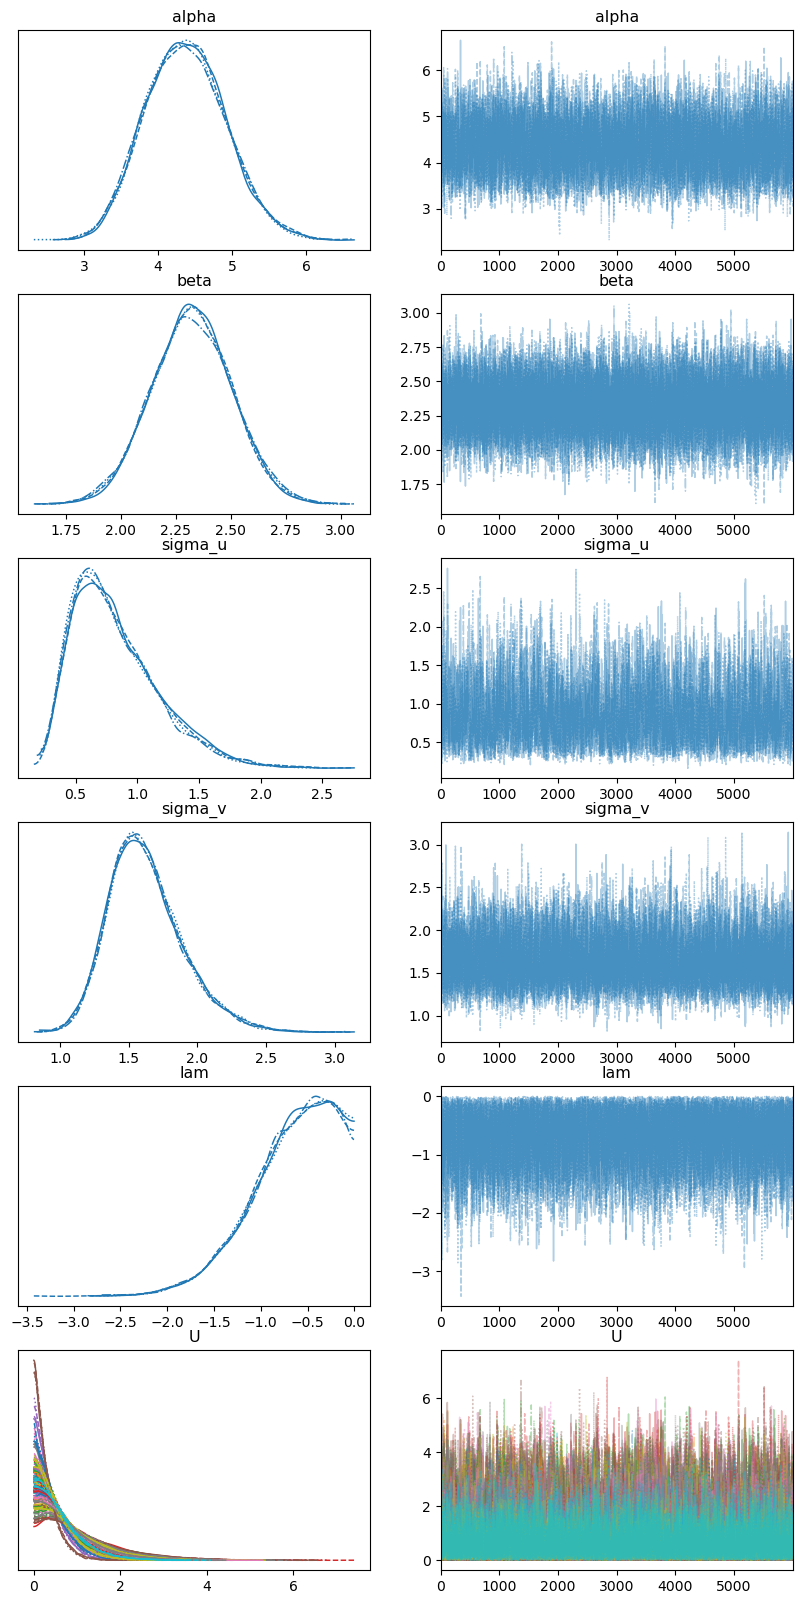

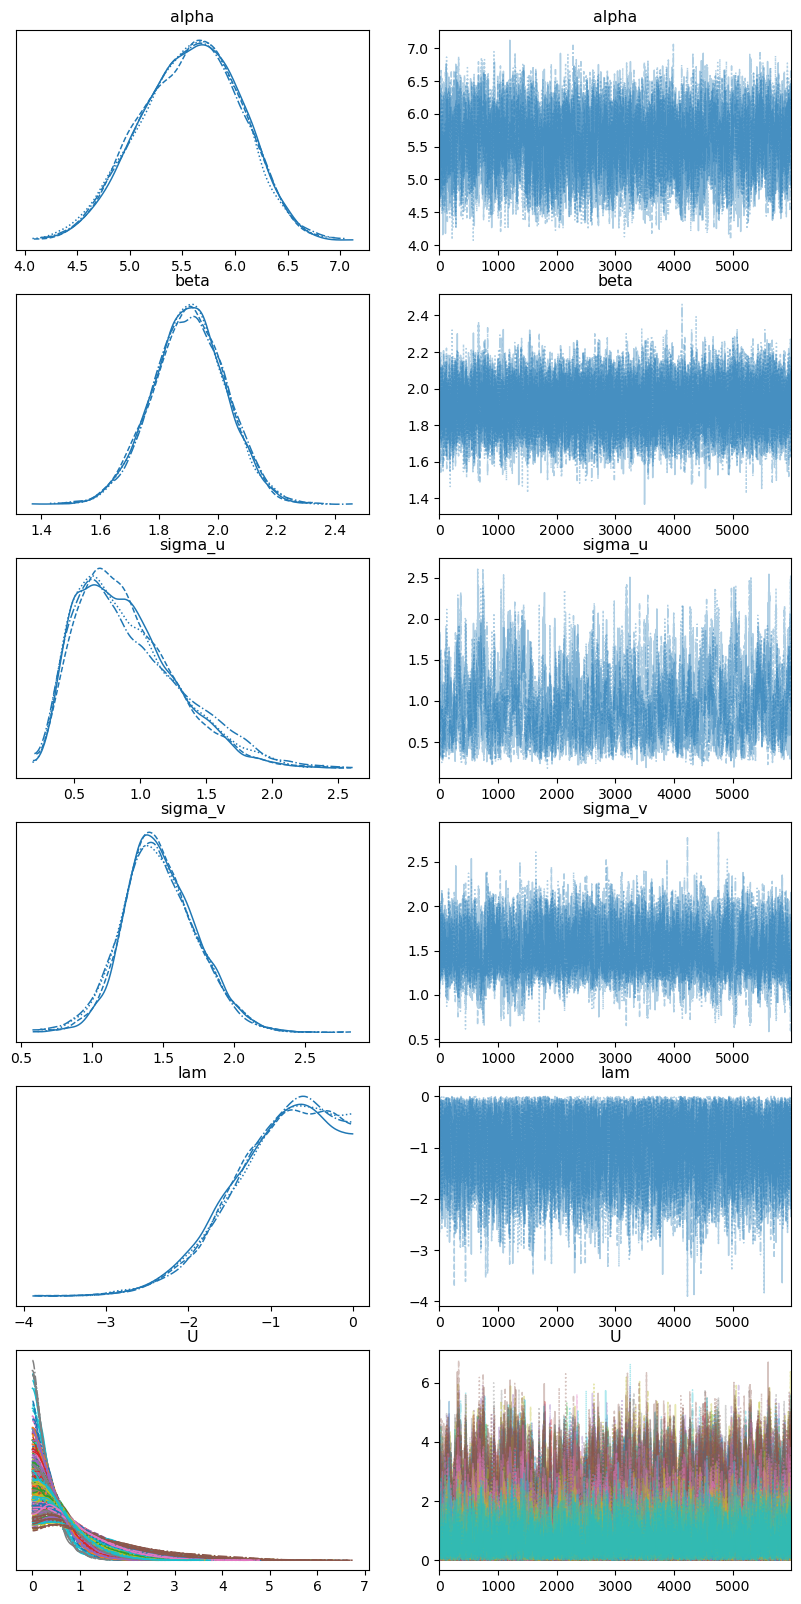

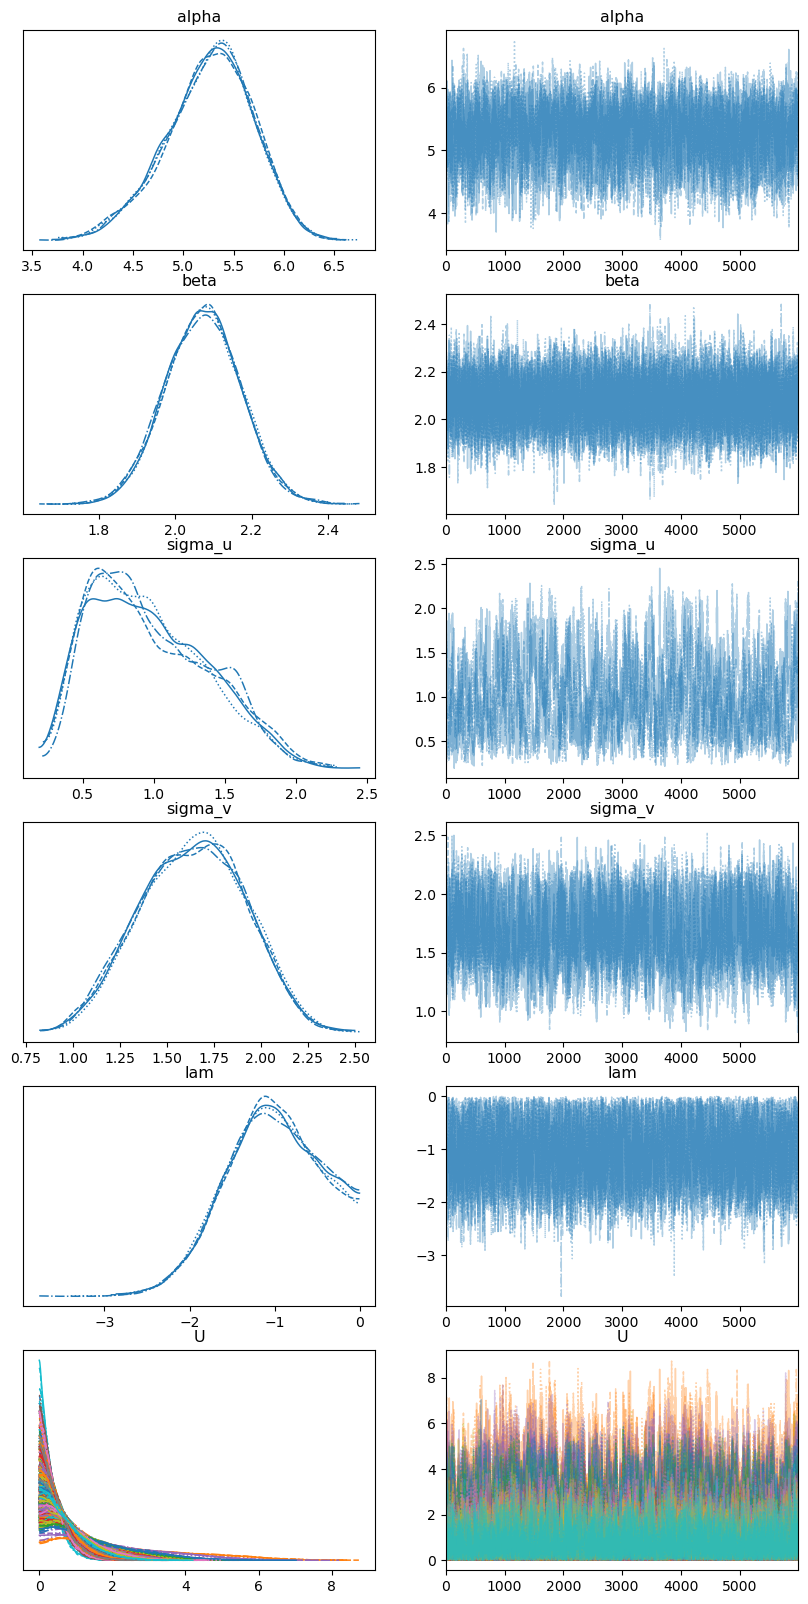

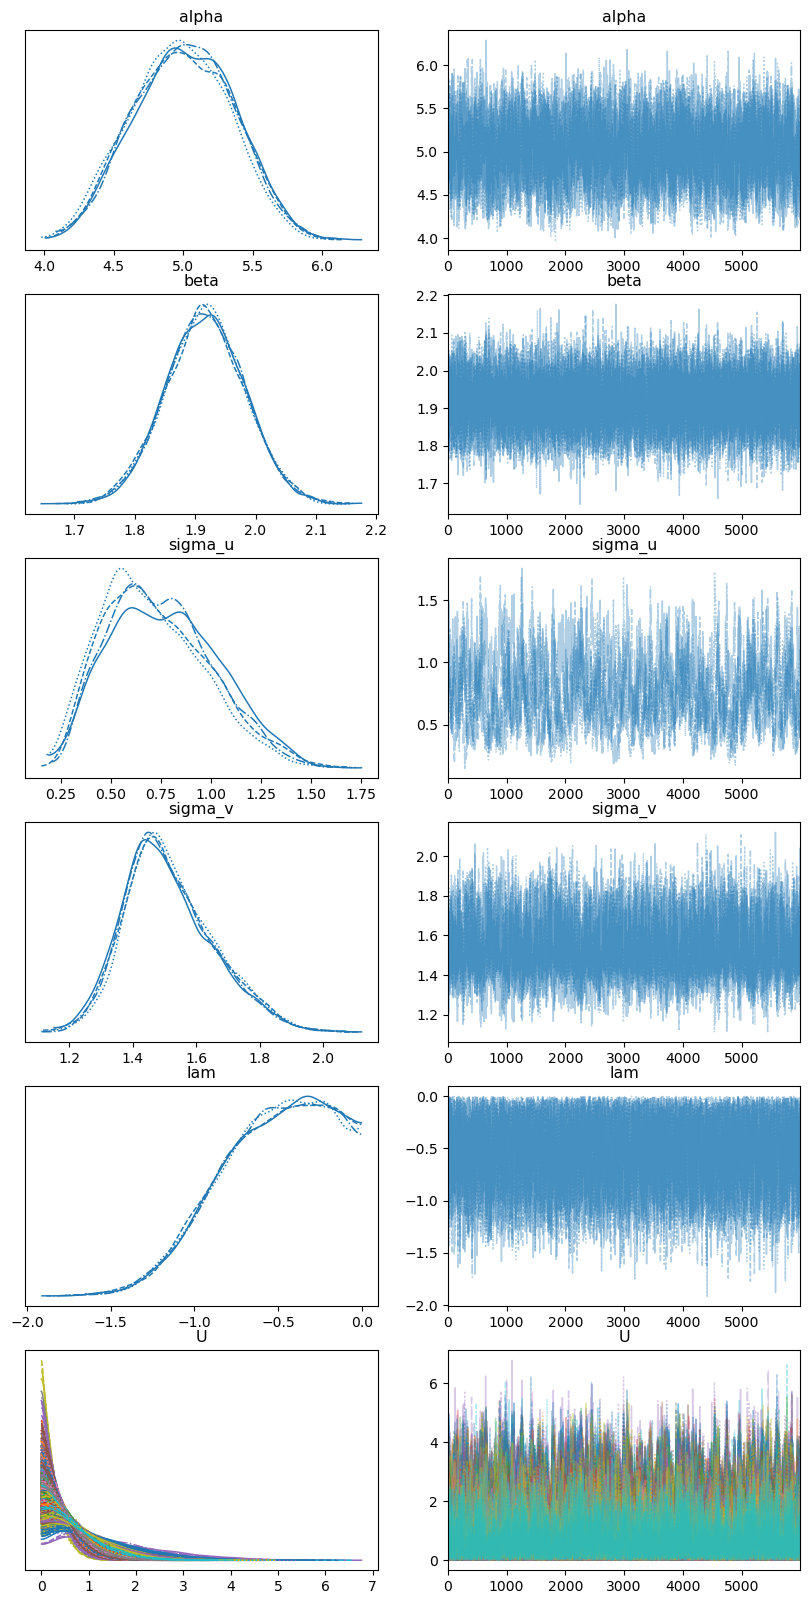

In [ ]:
for i in range(4):  # Loop from 0 to 3
    print(f"Trace Skew {i + 1}")
    az.plot_trace(trace_skew[i][1], figsize=(10, 20))  # Use the second element (inference data)
    display(az.summary(trace_skew[i][1], round_to=2))  # Use the second element (inference data)

# Posterior Summaries: Normal

Trace Norm 1


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    3.71  0.40    2.97     4.47       0.01     0.00   3427.79   4477.02   
beta     2.33  0.18    2.00     2.69       0.00     0.00  20663.25  17795.49   
sigma_u  0.82  0.35    0.26     1.47       0.01     0.01   2257.99   3838.92   
sigma_v  1.44  0.18    1.11     1.77       0.00     0.00   7804.91   7275.23   
U[0]     0.55  0.48    0.00     1.42       0.01     0.01   7409.29   9385.41   
U[1]     0.82  0.70    0.00     2.10       0.01     0.01   4456.39   7972.50   
U[2]     1.03  0.84    0.00     2.61       0.01     0.01   3588.42   6656.04   
U[3]     1.09  0.89    0.00     2.74       0.02     0.01   3374.14   6256.63   
U[4]     0.37  0.33    0.00     0.98       0.00     0.00  13457.04   9915.50   
U[5]     0.59  0.52    0.00     1.54       0.01     0.01   7502.76  11022.40   
U[6]     0.43  0.38    0.00     1.11       0.00     0.00  10997.62   9509.34   
U[7]     0.68  0.58    0.00     1.74       0.01     0.01   5139.23   7587.41   
U[8]     0.50  0.44    0.00     1.30       0.00     0.00  10368.07  10954.29   
U[9]     0.63  0.54    0.00     1.61       0.01     0.01   6006.95   8798.03   
U[10]    0.54  0.46    0.00     1.38       0.00     0.00   8188.30   9021.81   
U[11]    0.65  0.55    0.00     1.64       0.01     0.01   6097.91   9314.89   
U[12]    0.60  0.51    0.00     1.54       0.01     0.01   6755.90   9259.90   
U[13]    0.51  0.44    0.00     1.32       0.00     0.00   9350.28  10659.49   
U[14]    0.56  0.48    0.00     1.44       0.01     0.01   7781.10  10368.74   
U[15]    0.67  0.58    0.00     1.74       0.01     0.01   5409.15   7384.48   
U[16]    0.93  0.78    0.00     2.37       0.01     0.01   4306.54   7383.43   
U[17]    0.45  0.39    0.00     1.16       0.00     0.00  10623.47  10212.68   
U[18]    0.77  0.65    0.00     1.97       0.01     0.01   5139.16   9033.27   
U[19]    0.58  0.50    0.00     1.50       0.01     0.01   7225.79   9665.94   
U[20]    0.43  0.38    0.00     1.12       0.00     0.00  11076.20   9447.49   
U[21]    0.62  0.53    0.00     1.57       0.01     0.01   6323.18   9605.47   
U[22]    0.66  0.57    0.00     1.70       0.01     0.01   5655.00   9181.03   
U[23]    0.65  0.55    0.00     1.66       0.01     0.01   6064.74  10197.56   
U[24]    0.70  0.60    0.00     1.80       0.01     0.01   5517.00   9512.92   
U[25]    0.81  0.68    0.00     2.06       0.01     0.01   5020.44   7572.40   
U[26]    0.54  0.47    0.00     1.38       0.00     0.00   8623.28  10626.53   
U[27]    0.53  0.47    0.00     1.38       0.00     0.01   7993.06   8780.65   
U[28]    0.63  0.54    0.00     1.61       0.01     0.01   6292.22   9600.84   
U[29]    0.66  0.55    0.00     1.66       0.01     0.01   6278.21   9807.36   
U[30]    0.66  0.56    0.00     1.70       0.01     0.01   6140.42  10145.51   
U[31]    0.74  0.63    0.00     1.90       0.01     0.01   5038.29   8800.94   
U[32]    0.88  0.73    0.00     2.23       0.01     0.01   4334.77   7629.43   
U[33]    0.59  0.50    0.00     1.48       0.01     0.01   7175.85   9712.00   
U[34]    0.65  0.56    0.00     1.68       0.01     0.01   6193.06   8582.36   
U[35]    1.11  0.91    0.00     2.80       0.02     0.01   3445.47   6042.89   
U[36]    0.49  0.43    0.00     1.28       0.00     0.00   9565.50  10721.84   
U[37]    0.98  0.81    0.00     2.49       0.01     0.01   3656.11   6931.74   
U[38]    0.86  0.72    0.00     2.18       0.01     0.01   4360.71   7202.96   
U[39]    0.55  0.48    0.00     1.41       0.01     0.00   7918.85  10536.38   
U[40]    0.63  0.53    0.00     1.60       0.01     0.01   6310.06  10327.76   
U[41]    0.54  0.47    0.00     1.38       0.00     0.00   8943.78   9528.69   
U[42]    0.52  0.45    0.00     1.33       0.00     0.00   8454.35  10508.03   
U[43]    0.64  0.54    0.00     1.64       0.01     0.01   6644.38   8884.20   
U[44]    0.51  0.44    0.00     1.33       0.00     0.00   9477.15  10290.61   
U[45]    

Trace Norm 2


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.89  0.35    4.26     5.54       0.01     0.01    578.40   2007.35   
beta     1.89  0.12    1.66     2.11       0.00     0.00  10870.28  15642.00   
sigma_u  0.91  0.40    0.30     1.67       0.02     0.01    456.30   1648.36   
sigma_v  1.24  0.16    0.92     1.53       0.01     0.00    789.96   1500.48   
U[0]     0.55  0.47    0.00     1.41       0.01     0.01   3529.56   7164.99   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.49  1.14    0.00     3.67       0.05     0.02    637.46   2144.41   
U[96]    0.90  0.72    0.00     2.24       0.02     0.01   1098.97   3464.22   
U[97]    0.56  0.46    0.00     1.40       0.01     0.01   2825.76   8489.76   
U[98]    0.63  0.51    0.00     1.57       0.01     0.01   2353.49   6320.60   
U[99]    0.60  0.50    0.00     1.52       0.01     0.01   3053.61   7015.10   

         r_hat  
alpha      1.0  
beta       1.0  
sigma_u    1.0  
sigma_v    1.0  
U[0]       1.0  
...        ...  
U[95]      1.0  
U[96]      1.0  
U[97]      1.0  
U[98]      1.0  
U[99]      1.0  

[104 rows x 9 columns]

Trace Norm 3


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.50  0.37    3.83     5.15       0.02     0.01    296.81   1011.67   
beta     2.08  0.10    1.88     2.26       0.00     0.00  15690.56  16212.81   
sigma_u  1.11  0.43    0.37     1.84       0.03     0.01    250.12    775.98   
sigma_v  1.31  0.15    1.01     1.57       0.01     0.00    361.35   1010.34   
U[0]     0.60  0.49    0.00     1.50       0.01     0.01   2310.51   9651.22   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.86  0.69    0.00     2.11       0.02     0.01   1213.03   4997.59   
U[196]   0.97  0.73    0.00     2.30       0.02     0.01    887.74   3928.70   
U[197]   0.50  0.43    0.00     1.29       0.01     0.00   4769.60   7828.70   
U[198]   0.86  0.67    0.00     2.07       0.02     0.01   1188.66   4982.66   
U[199]   0.77  0.60    0.00     1.87       0.02     0.01   1630.90   5892.78   

         r_hat  
alpha     1.01  
beta      1.00  
sigma_u   1.01  
sigma_v   1.01  
U[0]      1.00  
...        ...  
U[195]    1.00  
U[196]    1.00  
U[197]    1.00  
U[198]    1.00  
U[199]    1.00  

[204 rows x 9 columns]

Trace Norm 4


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.47  0.23    4.07     4.91       0.01     0.00    550.59   1343.99   
beta     1.92  0.07    1.79     2.04       0.00     0.00  30051.07  16592.09   
sigma_u  0.73  0.26    0.29     1.22       0.01     0.01    475.00   1089.58   
sigma_v  1.39  0.07    1.25     1.52       0.00     0.00    907.44   1557.62   
U[0]     0.84  0.67    0.00     2.06       0.02     0.01   1456.08   3470.24   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.43  0.38    0.00     1.13       0.01     0.00   5381.19  11397.07   
U[496]   0.50  0.41    0.00     1.25       0.01     0.00   3366.22   7520.78   
U[497]   0.49  0.41    0.00     1.25       0.01     0.01   3617.14   7654.40   
U[498]   0.76  0.61    0.00     1.88       0.02     0.01   1648.75   3890.76   
U[499]   0.68  0.55    0.00     1.69       0.01     0.01   2036.68   4250.82   

         r_hat  
alpha     1.01  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
U[0]      1.00  
...        ...  
U[495]    1.00  
U[496]    1.00  
U[497]    1.00  
U[498]    1.00  
U[499]    1.00  

[504 rows x 9 columns]

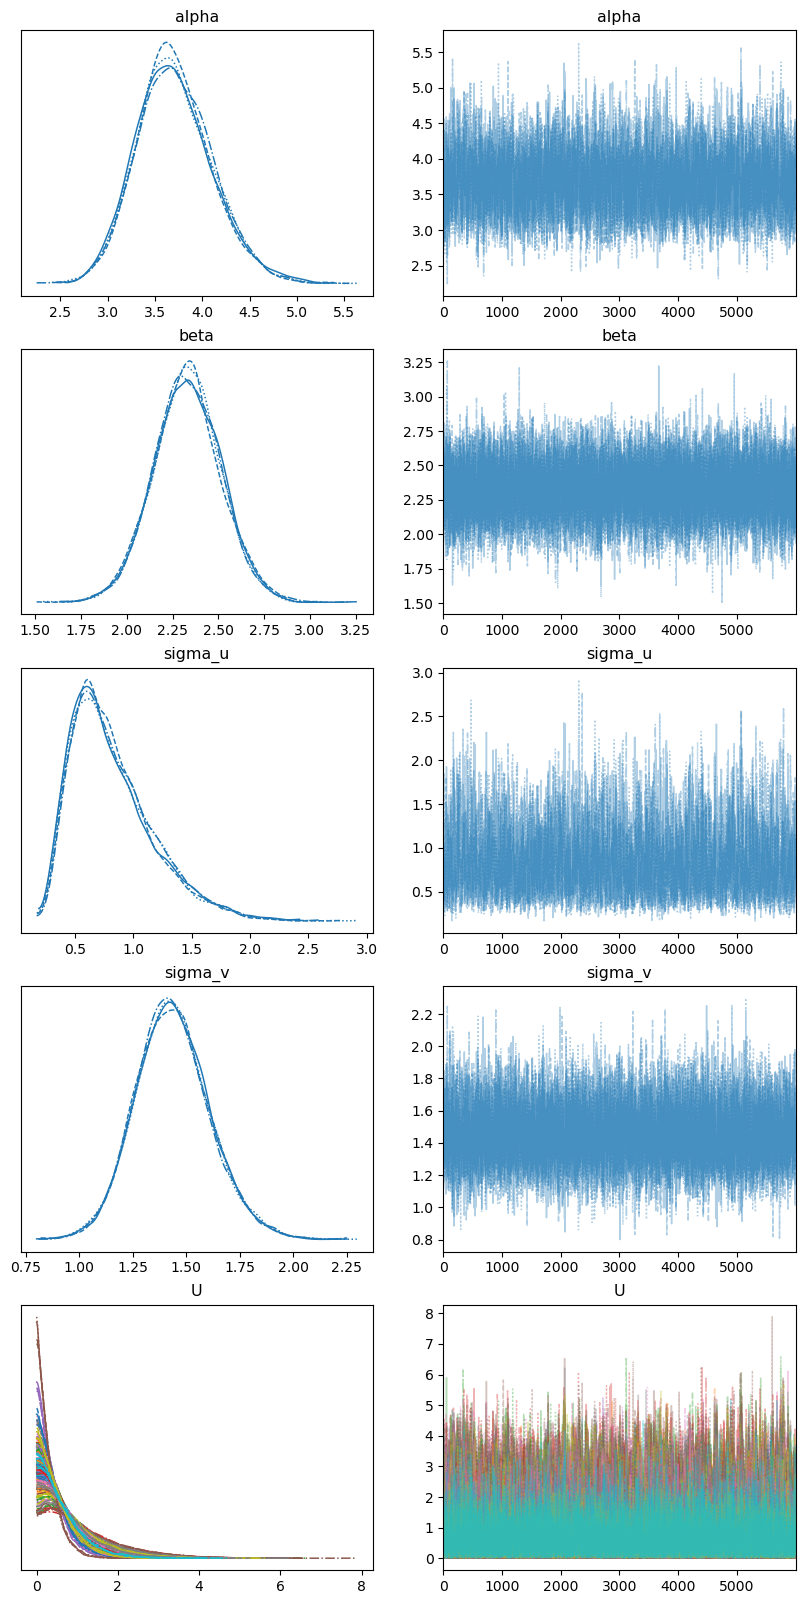

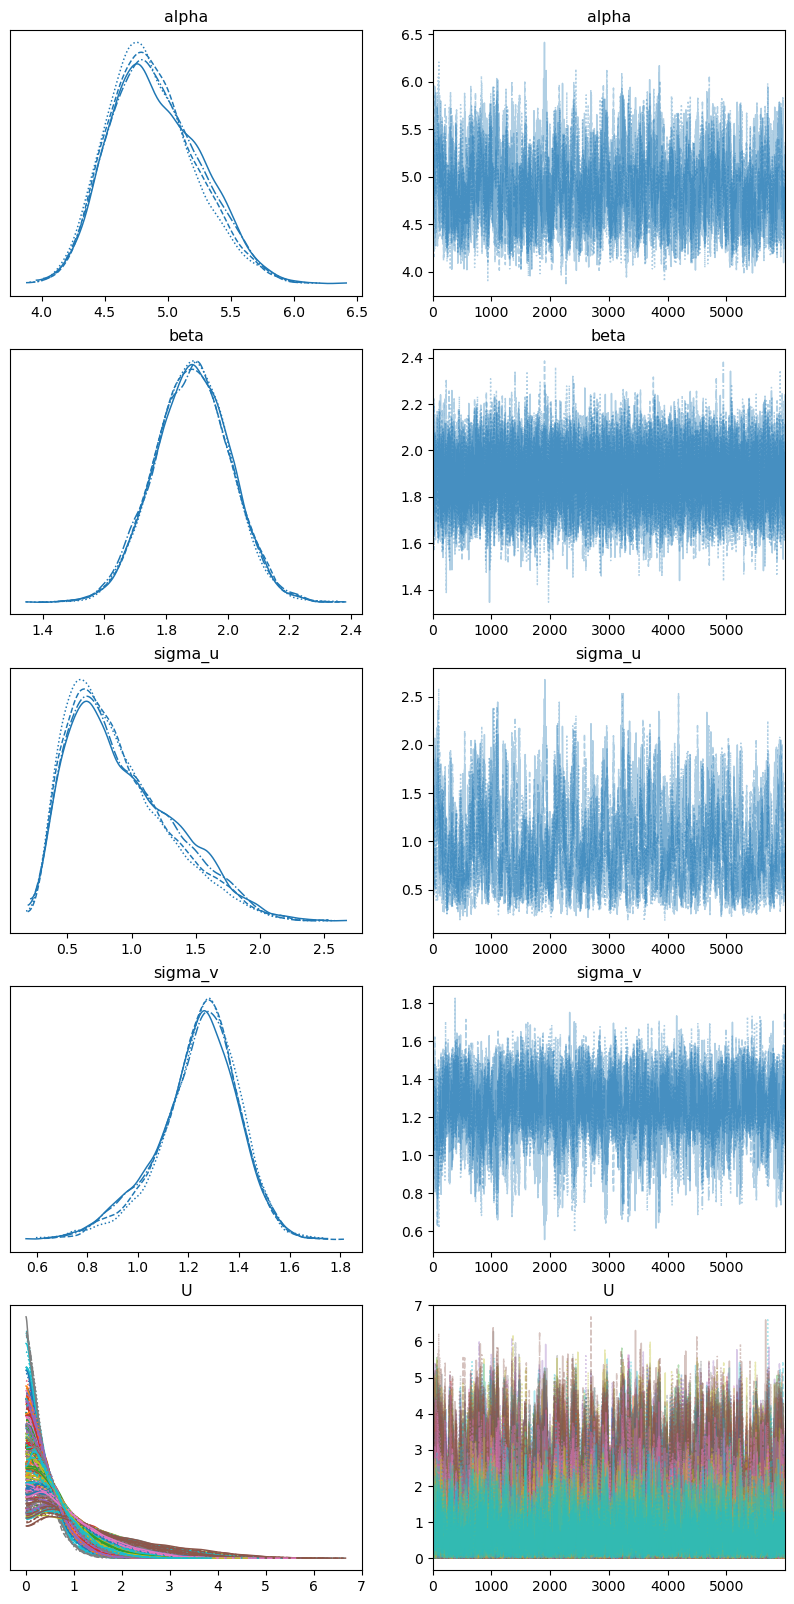

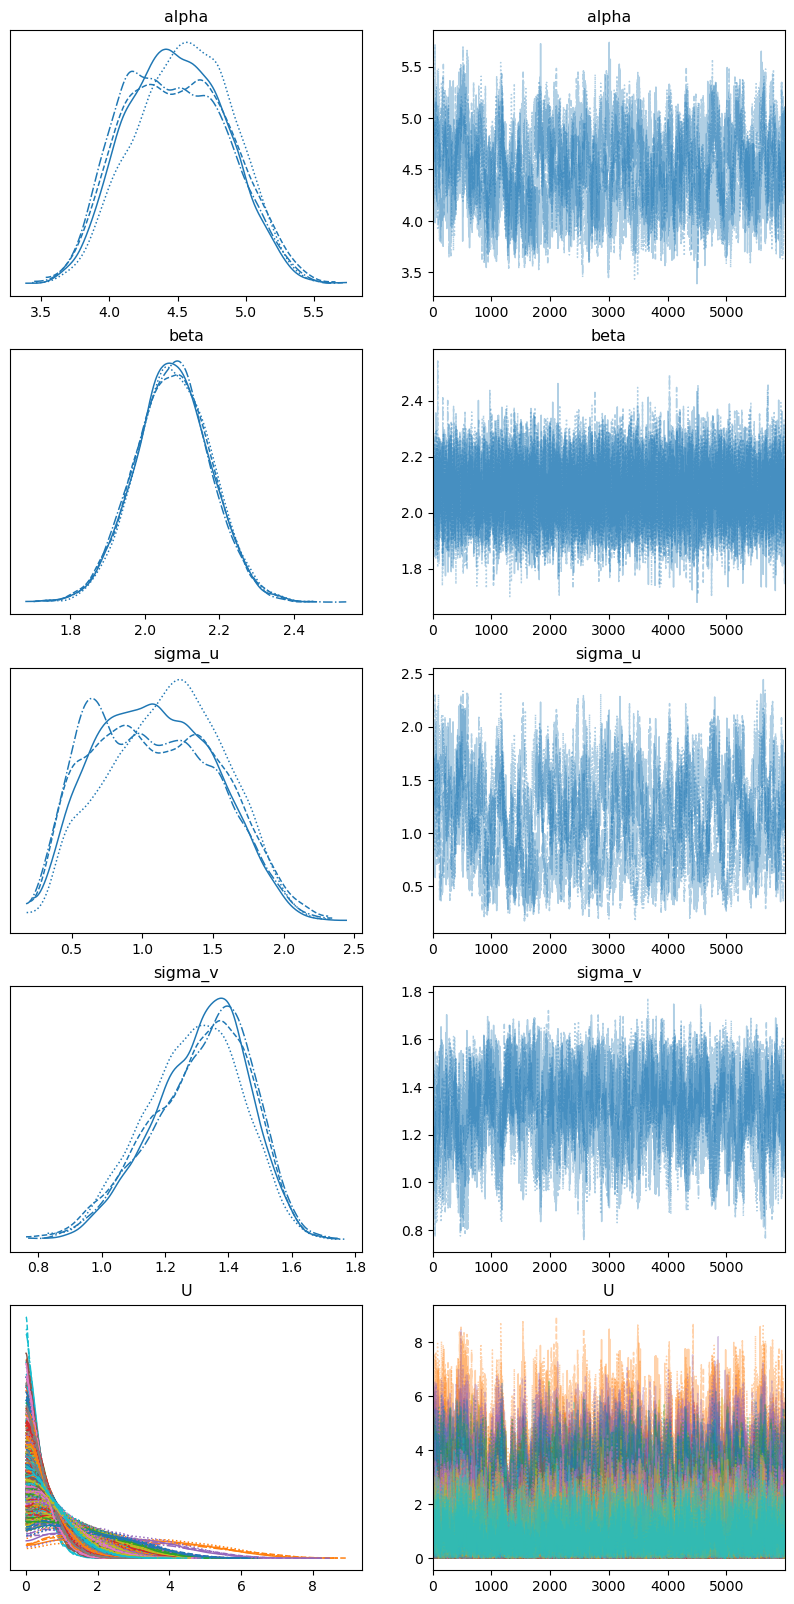

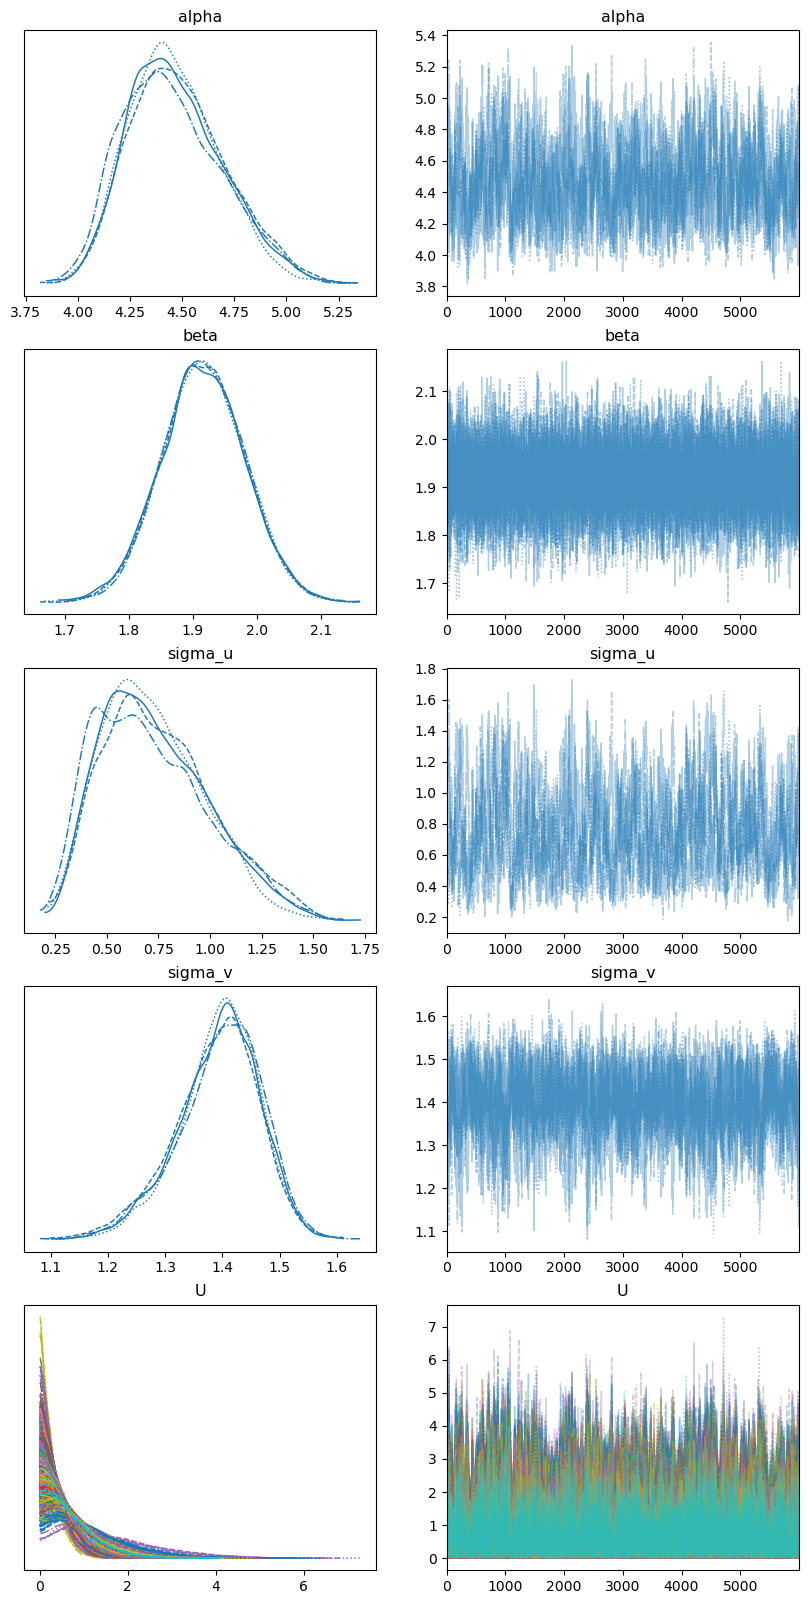

In [14]:
for i in range(4):  # Loop from 0 to 3
    print(f"Trace Norm {i + 1}")
    az.plot_trace(trace_norm[i][1], figsize=(10, 20))  # Use the second element (InferenceData)
    display(az.summary(trace_norm[i][1], round_to=2))  # Use the second element (InferenceData)

# Model Comparison

## Leave-One-Out (LOO)

In [18]:
for i in range(len(trace_skew)):  # Loop through the indices of trace_skew and trace_norm
    print(f"Comparison for sample size {sample_size[i]}:")
    df_comp_loo = az.compare({"Skew Normal": trace_skew[i][1], "Normal": trace_norm[i][1]})
    display(df_comp_loo)

Comparison for sample size 50:


/opt/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank   elpd_loo     p_loo  elpd_diff  weight        se       dse  \
Normal          0 -93.544358  8.453644   0.000000     1.0  6.707608  0.000000   
Skew Normal     1 -94.044245  8.724485   0.499887     0.0  7.084459  0.490211   

             warning scale  
Normal         False   log  
Skew Normal     True   log

Comparison for sample size 100:


/opt/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    elpd_loo      p_loo  elpd_diff  weight        se  \
Normal          0 -174.537886  20.849697   0.000000     1.0  6.526561   
Skew Normal     1 -174.683120  20.344264   0.145234     0.0  6.609398   

                  dse  warning scale  
Normal       0.000000     True   log  
Skew Normal  0.321858    False   log

Comparison for sample size 200:


/opt/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This

rank    elpd_loo      p_loo  elpd_diff  weight         se  \
Skew Normal     0 -364.654136  39.421705   0.000000     1.0  11.543787   
Normal          1 -364.986411  48.584217   0.332275     0.0  11.933946   

                  dse  warning scale  
Skew Normal  0.000000     True   log  
Normal       0.837121     True   log

Comparison for sample size 500:


/opt/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    elpd_loo      p_loo  elpd_diff  weight         se  \
Normal          0 -903.433305  53.528245   0.000000     1.0  17.759814   
Skew Normal     1 -903.781632  53.777958   0.348327     0.0  17.819818   

                  dse  warning scale  
Normal       0.000000    False   log  
Skew Normal  0.568715     True   log

## RMSE Parameter Estimates

In [ ]:
true_vals_skew = np.array([5, 2, 1.5, 1, -1])
true_vals_norm = np.array([5, 2, 1.5, 1])
n_values = [50, 100, 200, 500]

for i in range(4):  # 0~3
    skew_summary = az.summary(trace_skew[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u", "lam"])
    norm_summary = az.summary(trace_norm[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u"])

    skew_means = skew_summary["mean"].values
    norm_means = norm_summary["mean"].values

    rmse_skew = np.sqrt((skew_means - true_vals_skew)**2)
    rmse_norm = np.sqrt((norm_means - true_vals_norm)**2)

    df = pd.DataFrame({
        "Parameter": ["alpha", "beta", "sigma_v", "sigma_u", "lambda"],
        "Skew Model RMSE": list(rmse_skew),
        "Normal Model RMSE": list(rmse_norm) + [np.nan]
    })

    print(f"\n RMSE Parameter Estimates (n = {n_values[i]})")
    display(df)



 RMSE Parameter Estimates (n = 50)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.629              1.294
1      beta            0.322              0.329
2   sigma_v            0.126              0.063
3   sigma_u            0.177              0.184
4    lambda            0.160                NaN


 RMSE Parameter Estimates (n = 100)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.575              0.114
1      beta            0.096              0.115
2   sigma_v            0.023              0.260
3   sigma_u            0.098              0.092
4    lambda            0.404                NaN


 RMSE Parameter Estimates (n = 200)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.262              0.497
1      beta            0.073              0.075
2   sigma_v            0.141              0.193
3   sigma_u            0.030              0.110
4    lambda            0.517                NaN


 RMSE Parameter Estimates (n = 500)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.001              0.533
1      beta            0.083              0.083
2   sigma_v            0.017              0.107
3   sigma_u            0.260              0.268
4    lambda            0.020                NaN

## RMSE Y_OBS

In [24]:
rmse_skew_list = []
rmse_norm_list = []

for i in range(4):  # corresponds to n=50, 100, 200, 500
    # Skew model
    with trace_skew[i][0]:
        ppc_skew = pm.sample_posterior_predictive(trace_skew[i][1], var_names=["Y_obs"])
    y_pred_skew = ppc_skew.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_skew = trace_skew[i][1].observed_data['Y_obs'].values
    rmse_skew = np.sqrt(np.mean((y_obs_skew - y_pred_skew) ** 2))
    rmse_skew_list.append(rmse_skew)

    # Normal model
    with trace_norm[i][0]:
        ppc_norm = pm.sample_posterior_predictive(trace_norm[i][1], var_names=["Y_obs"])
    y_pred_norm = ppc_norm.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_norm = trace_norm[i][1].observed_data['Y_obs'].values
    rmse_norm = np.sqrt(np.mean((y_obs_norm - y_pred_norm) ** 2))
    rmse_norm_list.append(rmse_norm)


for idx, n_val in enumerate([50, 100, 200, 500]):
    print(f"n = {n_val} → RMSE_Skew: {rmse_skew_list[idx]:.4f}, RMSE_Norm: {rmse_norm_list[idx]:.4f}")

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

n = 50 → RMSE_Skew: 1.3011, RMSE_Norm: 1.3008
n = 100 → RMSE_Skew: 1.1125, RMSE_Norm: 1.1056
n = 200 → RMSE_Skew: 1.2230, RMSE_Norm: 1.1465
n = 500 → RMSE_Skew: 1.3155, RMSE_Norm: 1.3168


## RMSE Ineffiency

In [37]:
import pandas as pd
from scipy.stats import halfnorm

rmse_u_skew_list = []
rmse_u_norm_list = []
n_values = [50, 100, 200, 500]

for i, n in enumerate(n_values):
    np.random.seed(123)
    U_true = halfnorm(scale=1).rvs(n)

    # Skew
    U_est_skew = trace_skew[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_skew = np.sqrt(np.mean((U_true - U_est_skew)**2))
    rmse_u_skew_list.append(rmse_u_skew)

    # Norm
    U_est_norm = trace_norm[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_norm = np.sqrt(np.mean((U_true - U_est_norm)**2))
    rmse_u_norm_list.append(rmse_u_norm)

# Make DataFrame
df_u_rmse = pd.DataFrame({
    "Sample Size (n)": n_values,
    "Skew Model RMSE (U)": rmse_u_skew_list,
    "Normal Model RMSE (U)": rmse_u_norm_list
})

display(df_u_rmse)


Sample Size (n)  Skew Model RMSE (U)  Normal Model RMSE (U)
0               50             0.765080               0.767679
1              100             0.727316               0.729817
2              200             0.686712               0.721252
3              500             0.661524               0.663244